## 2. Install/import libraries

# Sentiment Analysis to predict stock price direction using Classifier models

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of AstraZeneca stock will increase or decrease based on sentiment analysis of market news articles from 2018-2023 collected by web scraping from [Investing.com](https://uk.investing.com/equities/astrazeneca-news).

Sentiment Analysis is the use of NLP, text analysis and
computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.




In [21]:
!pip install yfinance

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import seaborn as sns
import math
import datetime
import re
import yfinance as yf
import nltk
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Import data

Read article sentiment data collected by web scraping from Investing.com into a DataFrame.



In [23]:
# Show DataFrame of article sentiments data

article_sentiments_amzn = pd.read_pickle('/AMZN_sentiments_data.pkl')
article_sentiments_aapl = pd.read_pickle('/AAPL_sentiments_data.pkl')
article_sentiments_msft = pd.read_pickle('/MSFT_sentiments_data.pkl')

In [24]:
# Create copy of DataFrame

article_sentiments_amzn = article_sentiments_amzn.copy()
article_sentiments_aapl = article_sentiments_aapl.copy()
article_sentiments_msft = article_sentiments_msft.copy()

## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [25]:
# Append ---newarticle--- to split for NLP
article_sentiments_amzn['body_text'] = article_sentiments_amzn['body_text'].astype(str) + '---newarticle---'
article_sentiments_aapl['body_text'] = article_sentiments_aapl['body_text'].astype(str) + '---newarticle---'
article_sentiments_msft['body_text'] = article_sentiments_msft['body_text'].astype(str) + '---newarticle---'

In [26]:
amzn_bodytext = article_sentiments_amzn['body_text']
aapl_bodytext = article_sentiments_aapl['body_text']
msft_bodytext = article_sentiments_msft['body_text']

In [27]:
pd.set_option("display.max_colwidth", -1)  # to display full text

In [28]:
# Save article_sentiments_{company} to txt

with open('/amzn_bodytext.txt', 'w') as f:
    f.write(
        amzn_bodytext.to_string(header = False, index = False)
    )
with open('/aapl_bodytext.txt', 'w') as f:
    f.write(
        aapl_bodytext.to_string(header = False, index = False)
    )
with open('/msft_bodytext.txt', 'w') as f:
    f.write(
        msft_bodytext.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [29]:
# first get all lines from file
with open('/amzn_bodytext.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('/amzn_bodytext.txt', 'w') as f:
    f.writelines(lines)

# first get all lines from file
with open('/aapl_bodytext.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('/aapl_bodytext.txt', 'w') as f:
    f.writelines(lines)

# first get all lines from file
with open('/msft_bodytext.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('/msft_bodytext.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [30]:
# first get all lines from file
a_file = open("/amzn_bodytext.txt", "r")
b_file = open("/aapl_bodytext.txt", "r")
c_file = open("/msft_bodytext.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

# iterate over strings
for line in b_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
b_file.close()

# iterate over strings
for line in c_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
c_file.close()

In [31]:
# finally, write lines in the file
with open('/amzn_bodytext.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

with open('/aapl_bodytext.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

with open('/msft_bodytext.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [32]:
# Read article sentiments data into DataFrame

amzn_news_df = pd.read_pickle('/AMZN_sentiments_data.pkl')
aapl_news_df = pd.read_pickle('/AAPL_sentiments_data.pkl')
msft_news_df = pd.read_pickle('/MSFT_sentiments_data.pkl')

In [33]:
# Check data types
amzn_news_df.dtypes

ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [34]:
# Create copy of DataFrame
amzn_news_df_new = amzn_news_df.copy()
aapl_news_df_new = aapl_news_df.copy()
msft_news_df_new = msft_news_df.copy()

### Drop rows without publish date

In [35]:
# Drop rows with None in publish_date column
amzn_news_df_new = amzn_news_df_new.replace(to_replace='None', value=np.nan).dropna()
aapl_news_df_new = aapl_news_df_new.replace(to_replace='None', value=np.nan).dropna()
msft_news_df_new = msft_news_df_new.replace(to_replace='None', value=np.nan).dropna()

### Drop rows with duplicate titles

In [36]:
# Dropping all duplicate titles keeping only the first instance

amzn_news_df_new.drop_duplicates(subset ="title",
                     keep = 'first', inplace = True)
aapl_news_df_new.drop_duplicates(subset ="title",
                     keep = 'first', inplace = True)
msft_news_df_new.drop_duplicates(subset ="title",
                     keep = 'first', inplace = True)

### Set datetime index

In [37]:
# Set string representation of date to datetime index

amzn_news_df_new['Date'] = pd.to_datetime(amzn_news_df_new.publish_date)
amzn_news_df_new.set_index('Date', inplace=True)

aapl_news_df_new['Date'] = pd.to_datetime(aapl_news_df_new.publish_date)
aapl_news_df_new.set_index('Date', inplace=True)

msft_news_df_new['Date'] = pd.to_datetime(msft_news_df_new.publish_date)
msft_news_df_new.set_index('Date', inplace=True)

In [38]:
# Show dateime index of new DataFrame
amzn_news_df_new.index

DatetimeIndex(['2023-10-30', '2023-10-31', '2023-11-10', '2023-11-02',
               '2023-10-27', '2023-10-31', '2023-11-13', '2023-11-13',
               '2023-10-29', '2023-11-01',
               ...
               '2021-10-18', '2021-10-18', '2021-10-15', '2021-10-17',
               '2021-10-20', '2021-10-20', '2021-10-18', '2021-10-17',
               '2021-10-19', '2021-10-20'],
              dtype='datetime64[ns]', name='Date', length=1017, freq=None)

### Sort in ascending chronological order

In [39]:
# Sort in chronological order
amzn_news_df_new = amzn_news_df_new.sort_index()
aapl_news_df_new = aapl_news_df_new.sort_index()
msft_news_df_new = msft_news_df_new.sort_index()

In [40]:
# Save sorted DataFrame
amzn_news_df_new.to_pickle("/AMZN_news_df_new.pkl")
aapl_news_df_new.to_pickle("/AAPL_news_df_new.pkl")
msft_news_df_new.to_pickle("/MSFT_news_df_new.pkl")

In [41]:
amzn_news_df_new.to_csv("/AMZN_news_df_new.csv", sep=',', encoding='utf-8', header=True)
aapl_news_df_new.to_csv("/AAPL_news_df_new.csv", sep=',', encoding='utf-8', header=True)
msft_news_df_new.to_csv("/MSFT_news_df_new.csv", sep=',', encoding='utf-8', header=True)

In [42]:
amzn_news_df_new.dtypes

ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [43]:
# Create copy of DataFrame
amzn_news_df_combined = amzn_news_df_new.copy()
aapl_news_df_combined = aapl_news_df_new.copy()
msft_news_df_combined = msft_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [44]:
# Combining all the news published on a single date in a separate column
amzn_news_df_combined['news_combined'] = amzn_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))
aapl_news_df_combined['news_combined'] = aapl_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))
msft_news_df_combined['news_combined'] = msft_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))

### Drop rows with duplicate dates

In [45]:
# Dropping duplicate dates keeping only the first instance

amzn_news_df_combined.drop_duplicates(subset ="publish_date",
                     keep = 'first', inplace = True)
aapl_news_df_combined.drop_duplicates(subset ="publish_date",
                     keep = 'first', inplace = True)
msft_news_df_combined.drop_duplicates(subset ="publish_date",
                     keep = 'first', inplace = True)

In [46]:
# Save combined DataFrame without duplicates
amzn_news_df_combined.to_csv("/amzn_news_df_combined.csv", sep=',', encoding='utf-8', header=True)
aapl_news_df_combined.to_csv("/aapl_news_df_combined.csv", sep=',', encoding='utf-8', header=True)
msft_news_df_combined.to_csv("/msft_news_df_combined.csv", sep=',', encoding='utf-8', header=True)

In [47]:
amzn_news_df_combined = pd.read_csv("/amzn_news_df_combined.csv")
aapl_news_df_combined = pd.read_csv("/aapl_news_df_combined.csv")
msft_news_df_combined = pd.read_csv("/msft_news_df_combined.csv")

### Set datetime index

In [48]:
# Set string representation of date to datetime index
amzn_news_df_combined['Date'] = pd.to_datetime(amzn_news_df_combined.publish_date)
amzn_news_df_combined.set_index('Date', inplace=True)
aapl_news_df_combined['Date'] = pd.to_datetime(aapl_news_df_combined.publish_date)
aapl_news_df_combined.set_index('Date', inplace=True)
msft_news_df_combined['Date'] = pd.to_datetime(msft_news_df_combined.publish_date)
msft_news_df_combined.set_index('Date', inplace=True)

## 5. Import historical stock data

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [49]:
amzn_stock_df = yf.download("AMZN", start="2018-10-01", end="2023-10-01")
aapl_stock_df = yf.download("AAPL", start="2018-10-01", end="2023-10-01")
msft_stock_df = yf.download("MSFT", start="2018-10-01", end="2023-10-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Visualise Adjusted Close price and Volume

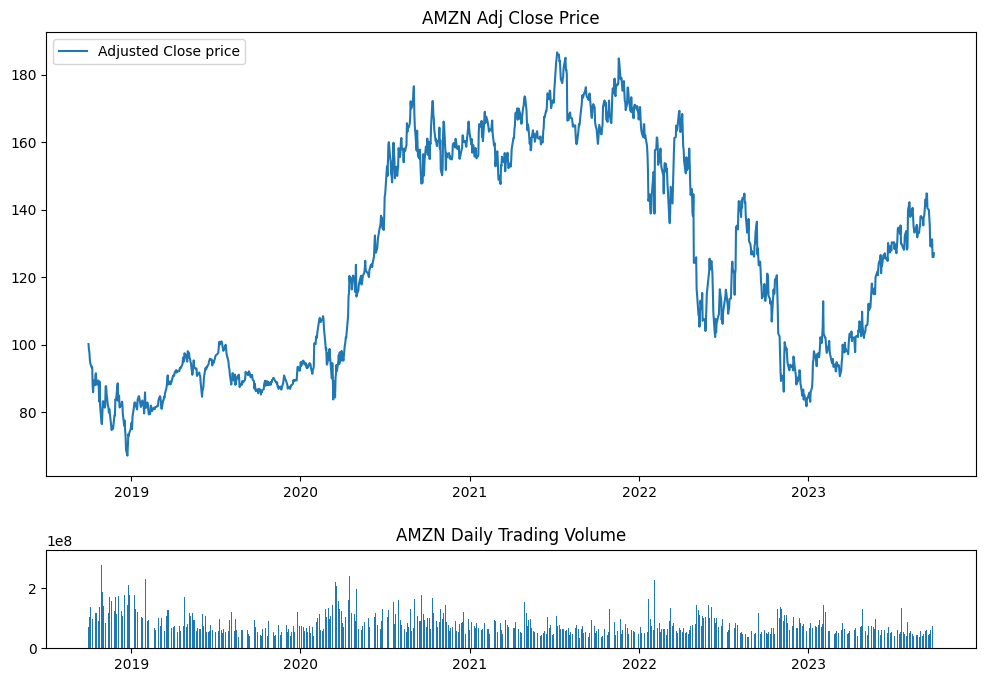

In [50]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(amzn_stock_df.index, amzn_stock_df['Adj Close'], label = 'Adjusted Close price')
plt.title('AMZN Adj Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(amzn_stock_df.index, amzn_stock_df["Volume"])
plt.title('AMZN Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

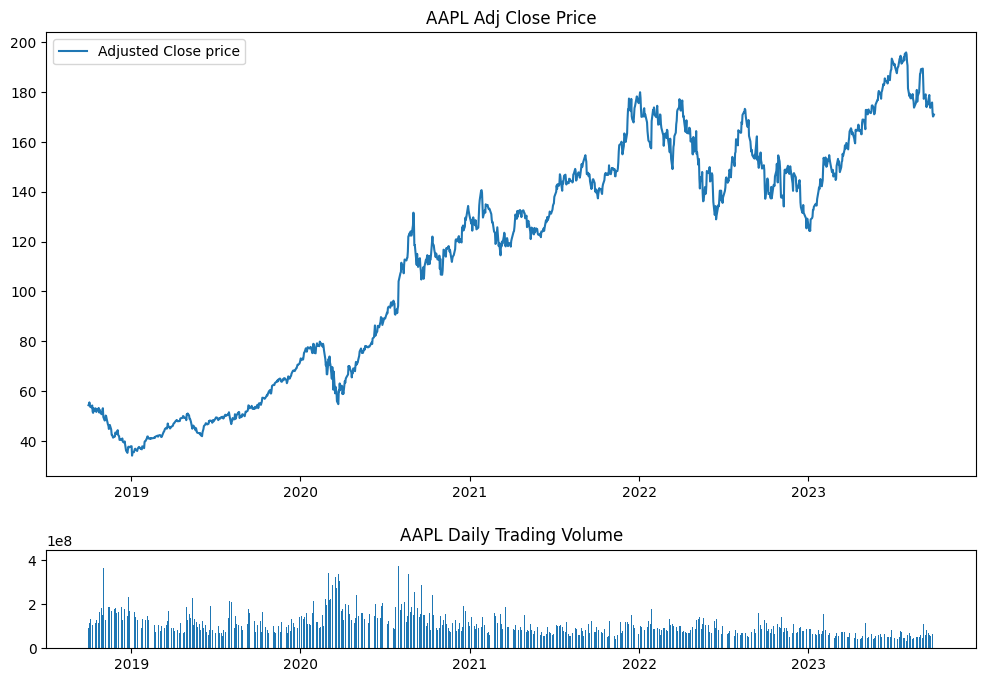

In [51]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(aapl_stock_df.index, aapl_stock_df['Adj Close'], label = 'Adjusted Close price')
plt.title('AAPL Adj Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(aapl_stock_df.index, aapl_stock_df["Volume"])
plt.title('AAPL Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

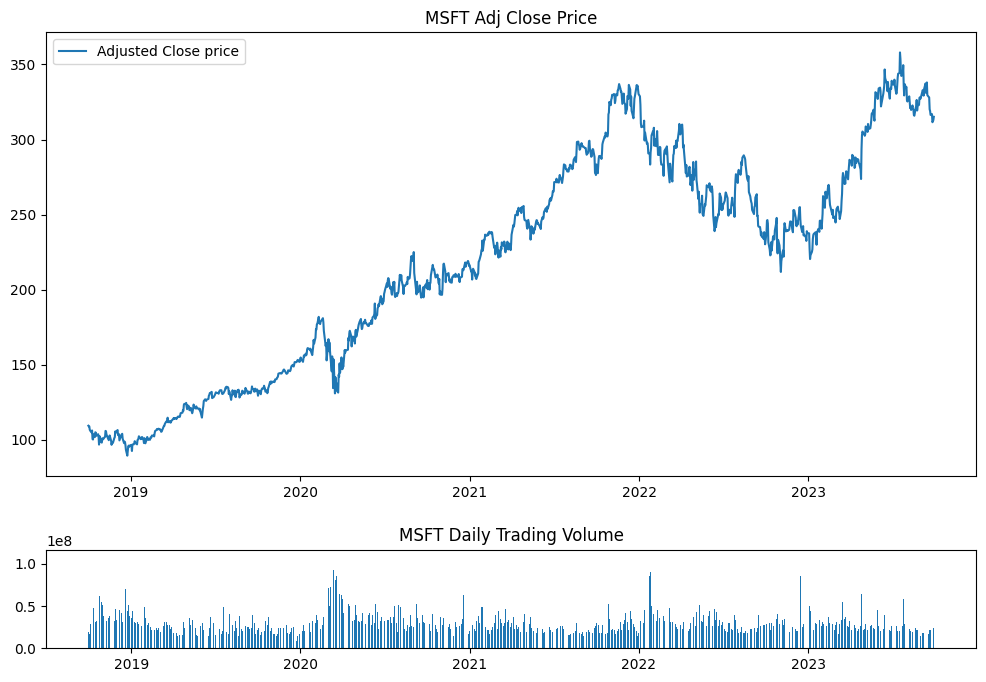

In [52]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(msft_stock_df.index, msft_stock_df['Adj Close'], label = 'Adjusted Close price')
plt.title('MSFT Adj Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(msft_stock_df.index, msft_stock_df["Volume"])
plt.title('MSFT Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [53]:
# Merge data sets on date
merge_amzn = amzn_stock_df.merge(amzn_news_df_combined, how='inner', left_index=True, right_index=True)
merge_aapl = aapl_stock_df.merge(aapl_news_df_combined, how='inner', left_index=True, right_index=True)
merge_msft = msft_stock_df.merge(msft_news_df_combined, how='inner', left_index=True, right_index=True)


In [54]:
# Save merged DataFrame

merge_amzn.to_csv("/amzn_news_stock_merge.csv", sep=',', encoding='utf-8', header=True)
merge_aapl.to_csv("/aapl_news_stock_merge.csv", sep=',', encoding='utf-8', header=True)
merge_msft.to_csv("/msft_news_stock_merge.csv", sep=',', encoding='utf-8', header=True)

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes.  

In [55]:
# Create empty list to append cleaned data from combined news column
clean_news_amzn = []
for i in range(0, len(merge_amzn["news_combined"])):
    clean_news_amzn.append(re.sub("\n", ' ', merge_amzn["news_combined"][i]))  # replace n\ with ' '
    clean_news_amzn[i] = re.sub(r'[^\w\d\s\']+', '', clean_news_amzn[i]) # remove unwanted punctuation and \'

clean_news_aapl = []
for i in range(0, len(merge_aapl["news_combined"])):
    clean_news_aapl.append(re.sub("\n", ' ', merge_aapl["news_combined"][i]))  # replace n\ with ' '
    clean_news_aapl[i] = re.sub(r'[^\w\d\s\']+', '', clean_news_aapl[i]) # remove unwanted punctuation and \'

clean_news_msft = []
for i in range(0, len(merge_msft["news_combined"])):
    clean_news_msft.append(re.sub("\n", ' ', merge_msft["news_combined"][i]))  # replace n\ with ' '
    clean_news_msft[i] = re.sub(r'[^\w\d\s\']+', '', clean_news_msft[i]) # remove unwanted punctuation and \'


In [56]:
# Add cleaned news column to merged data set

merge_amzn['news_cleaned'] = clean_news_amzn
merge_aapl['news_cleaned'] = clean_news_aapl
merge_msft['news_cleaned'] = clean_news_msft

In [57]:
# Save merged DataFrame

merge_amzn.to_csv("/amzn_merge_cleaned.csv", sep=',', encoding='utf-8', header=True)
merge_aapl.to_csv("/aapl_merge_cleaned.csv", sep=',', encoding='utf-8', header=True)
merge_msft.to_csv("/msft_merge_cleaned.csv", sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [58]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [59]:
# Create new columns
merge_amzn['subjectivity'] = merge_amzn['news_cleaned'].apply(getSubjectivity)
merge_amzn['polarity'] = merge_amzn['news_cleaned'].apply(getPolarity)

merge_aapl['subjectivity'] = merge_aapl['news_cleaned'].apply(getSubjectivity)
merge_aapl['polarity'] = merge_aapl['news_cleaned'].apply(getPolarity)

merge_msft['subjectivity'] = merge_msft['news_cleaned'].apply(getSubjectivity)
merge_msft['polarity'] = merge_msft['news_cleaned'].apply(getPolarity)

In [60]:
# Save DataFrame with subjectivity and polarity scores
merge_amzn.to_csv("/amzn_merge_cleaned_subj_pol.csv", sep=',', encoding='utf-8', header=True)
merge_aapl.to_csv("/aapl_merge_cleaned_subj_pol.csv", sep=',', encoding='utf-8', header=True)
merge_msft.to_csv("/msft_merge_cleaned_subj_pol.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [61]:
# Create copy of stock data

amzn_stock_df_label = amzn_stock_df.copy()
aapl_stock_df_label = aapl_stock_df.copy()
msft_stock_df_label = msft_stock_df.copy()

In [62]:
# "1" when Company Adj Close value rose or stayed as the same;
# "0" when Company Adj Close value decreased.

amzn_stock_df_label['Adj Close Next'] = amzn_stock_df_label['Adj Close'].shift(-1)
amzn_stock_df_label['Label'] = amzn_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

aapl_stock_df_label['Adj Close Next'] = aapl_stock_df_label['Adj Close'].shift(-1)
aapl_stock_df_label['Label'] = aapl_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

msft_stock_df_label['Adj Close Next'] = msft_stock_df_label['Adj Close'].shift(-1)
msft_stock_df_label['Label'] = msft_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)


In [63]:
# Save DataFrame
amzn_stock_df_label.to_pickle("/amzn_stock_df_labels.pkl")
aapl_stock_df_label.to_pickle("/aapl_stock_df_labels.pkl")
msft_stock_df_label.to_pickle("/msft_stock_df_labels.pkl")

In [64]:
amzn_stock_df_label.to_csv("/amzn_stock_df_label.csv", sep=',', encoding='utf-8', header=True)
aapl_stock_df_label.to_csv("/aapl_stock_df_label.csv", sep=',', encoding='utf-8', header=True)
msft_stock_df_label.to_csv("/msft_stock_df_label.csv", sep=',', encoding='utf-8', header=True)

In [65]:
# Show Adj Close Next and Label with Date

amzn_stock_df_label_adj_nxt = amzn_stock_df_label[['Adj Close Next', 'Label']]
aapl_stock_df_label_adj_nxt = aapl_stock_df_label[['Adj Close Next', 'Label']]
msft_stock_df_label_adj_nxt = msft_stock_df_label[['Adj Close Next', 'Label']]

In [66]:
# Drop NaN row

amzn_stock_df_label_adj_nxt = amzn_stock_df_label_adj_nxt.dropna()
aapl_stock_df_label_adj_nxt = aapl_stock_df_label_adj_nxt.dropna()
msft_stock_df_label_adj_nxt = msft_stock_df_label_adj_nxt.dropna()

In [67]:
# Merge DataFrames on date
merge_amzn2 = amzn_stock_df.merge(amzn_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)
merge_aapl2 = aapl_stock_df.merge(aapl_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)
merge_msft2 = msft_stock_df.merge(msft_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [68]:
# Drop NaN row and show merged DataFrame
merge_amzn2 = merge_amzn2.dropna()
merge_aapl2 = merge_aapl2.dropna()
merge_msft2 = merge_msft2.dropna()


In [69]:
# Save DataFrame
merge_amzn2.to_csv("/amzn_prices_labels.csv", sep=',', encoding='utf-8', header=True)
merge_aapl2.to_csv("/aapl_prices_labels.csv", sep=',', encoding='utf-8', header=True)
merge_msft2.to_csv("/msft_prices_labels.csv", sep=',', encoding='utf-8', header=True)

In [70]:
merge_amzn2.to_pickle("/amzn_prices_labels.pkl")
merge_aapl2.to_pickle("/aapl_prices_labels.pkl")
merge_msft2.to_pickle("/msft_prices_labels.pkl")

In [71]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge_amzn3 = amzn_stock_df_label_adj_nxt.merge(merge_amzn, how='inner', left_index=True, right_index=True)
merge_aapl3 = aapl_stock_df_label_adj_nxt.merge(merge_aapl, how='inner', left_index=True, right_index=True)
merge_msft3 = msft_stock_df_label_adj_nxt.merge(merge_msft, how='inner', left_index=True, right_index=True)

In [72]:
# Save merged DataFrame

merge_amzn3.to_csv("/amzn_prices_labels_news.csv", sep=',', encoding='utf-8', header=True)
merge_aapl3.to_csv("/aapl_prices_labels_news.csv", sep=',', encoding='utf-8', header=True)
merge_msft3.to_csv("/msft_prices_labels_news.csv", sep=',', encoding='utf-8', header=True)

In [73]:
merge_amzn3.to_pickle("/amzn_prices_labels_news.pkl")
merge_aapl3.to_pickle("/aapl_prices_labels_news.pkl")
merge_msft3.to_pickle("/msft_prices_labels_news.pkl")

In [74]:
merge_amzn3 = pd.read_pickle("/amzn_prices_labels_news.pkl")
merge_aapl3 = pd.read_pickle("/aapl_prices_labels_news.pkl")
merge_msft3 = pd.read_pickle("/msft_prices_labels_news.pkl")

In [75]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
amzn_df =  merge_amzn3[keep_columns]
aapl_df =  merge_aapl3[keep_columns]
msft_df =  merge_msft3[keep_columns]

## 10. Modelling

Split the data in feature matrix (X) and target vector (y).


In [76]:
# Create feature data set
X_amzn = amzn_df
X_amzn = np.array(X_amzn.drop(['Label'], 1))

X_aapl = aapl_df
X_aapl = np.array(X_aapl.drop(['Label'], 1))

X_msft = msft_df
X_msft = np.array(X_msft.drop(['Label'], 1))

# Create target data set
y_amzn = np.array(amzn_df['Label'])
y_aapl = np.array(aapl_df['Label'])
y_msft = np.array(msft_df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [77]:
# Split data into 80% training and 20% testing data sets

split_amzn = int(0.8*len(amzn_df))
split_aapl = int(0.8*len(aapl_df))
split_msft = int(0.8*len(msft_df))

In [79]:
X_amzn_train = X_amzn[0:split_amzn]
y_amzn_train = y_amzn[0:split_amzn]
X_aapl_train = X_aapl[0:split_aapl]
y_aapl_train = y_aapl[0:split_aapl]
X_msft_train = X_msft[0:split_msft]
y_msft_train = y_msft[0:split_msft]

X_amzn_test = X_amzn[split_amzn:]
y_amzn_test = y_amzn[split_amzn:]
X_aapl_test = X_aapl[split_aapl:]
y_aapl_test = y_aapl[split_aapl:]
X_msft_test = X_msft[split_msft:]
y_msft_test = y_msft[split_msft:]

In [80]:
print("AMZN: ", X_amzn_train.shape, y_amzn_train.shape, X_amzn_test.shape, y_amzn_test.shape)
print("AAPL: ", X_aapl_train.shape, y_aapl_train.shape, X_aapl_test.shape, y_aapl_test.shape)
print("MSFT: ", X_msft_train.shape, y_msft_train.shape, X_msft_test.shape, y_msft_test.shape)

AMZN:  (263, 12) (263,) (66, 12) (66,)
AAPL:  (214, 12) (214,) (54, 12) (54,)
MSFT:  (298, 12) (298,) (75, 12) (75,)


In [81]:
# Create and train the model
amzn_model = LinearDiscriminantAnalysis().fit(X_amzn_train, y_amzn_train)
aapl_model = LinearDiscriminantAnalysis().fit(X_aapl_train, y_aapl_train)
msft_model = LinearDiscriminantAnalysis().fit(X_msft_train, y_msft_train)

In [82]:
# Show model's predictions
predictions_amzn = amzn_model.predict(X_amzn_test)
predictions_aapl = aapl_model.predict(X_aapl_test)
predictions_msft = msft_model.predict(X_msft_test)

In [83]:
# Show model metrics
print("AMZN Model: ")
print(classification_report(y_amzn_test, predictions_amzn))
print("AAPL Model: ")
print(classification_report(y_aapl_test, predictions_aapl))
print("MSFT Model: ")
print(classification_report(y_msft_test, predictions_msft))

AMZN Model: 
              precision    recall  f1-score   support

           0       0.53      0.94      0.67        31
           1       0.82      0.26      0.39        35

    accuracy                           0.58        66
   macro avg       0.67      0.60      0.53        66
weighted avg       0.68      0.58      0.52        66

AAPL Model: 
              precision    recall  f1-score   support

           0       0.48      0.85      0.61        26
           1       0.50      0.14      0.22        28

    accuracy                           0.48        54
   macro avg       0.49      0.49      0.42        54
weighted avg       0.49      0.48      0.41        54

MSFT Model: 
              precision    recall  f1-score   support

           0       0.51      0.92      0.66        38
           1       0.57      0.11      0.18        37

    accuracy                           0.52        75
   macro avg       0.54      0.51      0.42        75
weighted avg       0.54      0.52  

### Feature scaling

We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [84]:
# Standardise X's
X_amzn_train = scale(X_amzn_train)
X_aapl_train = scale(X_aapl_train)
X_msft_train = scale(X_msft_train)

X_amzn_test = scale(X_amzn_test)
X_aapl_test = scale(X_aapl_test)
X_msft_test = scale(X_msft_test)

### Create function for confusion matrix to visualise performance

In [85]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"],
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

### Create dictionary of classifiers to train and predict on


-------------- LinearDiscriminantAnalysis ---------------



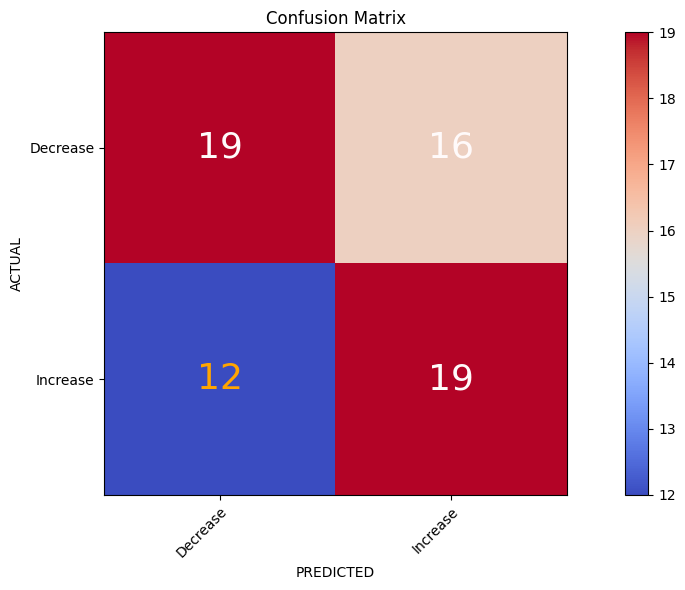

              precision    recall  f1-score   support

    Decrease       0.61      0.54      0.58        35
    Increase       0.54      0.61      0.58        31

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.58      0.58      0.58        66


-------------- SVM Classification ---------------



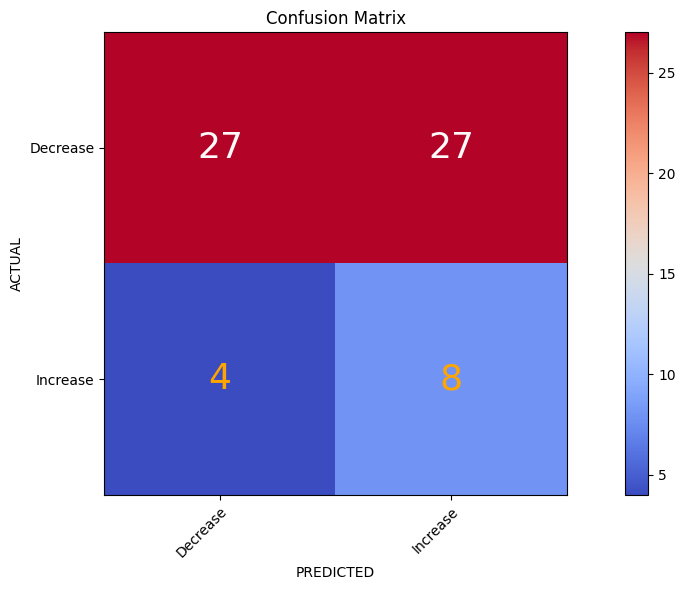

              precision    recall  f1-score   support

    Decrease       0.87      0.50      0.64        54
    Increase       0.23      0.67      0.34        12

    accuracy                           0.53        66
   macro avg       0.55      0.58      0.49        66
weighted avg       0.75      0.53      0.58        66


-------------- SGDClassifier ---------------



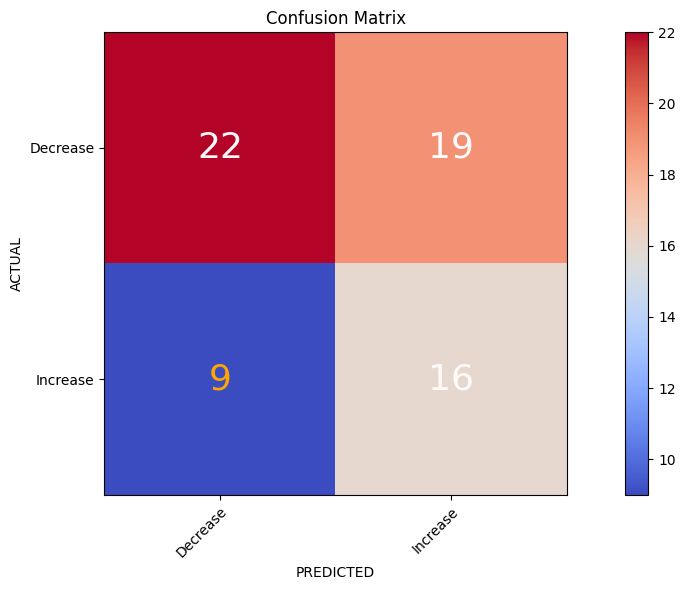

              precision    recall  f1-score   support

    Decrease       0.71      0.54      0.61        41
    Increase       0.46      0.64      0.53        25

    accuracy                           0.58        66
   macro avg       0.58      0.59      0.57        66
weighted avg       0.61      0.58      0.58        66


-------------- KNeighborsClassifier ---------------



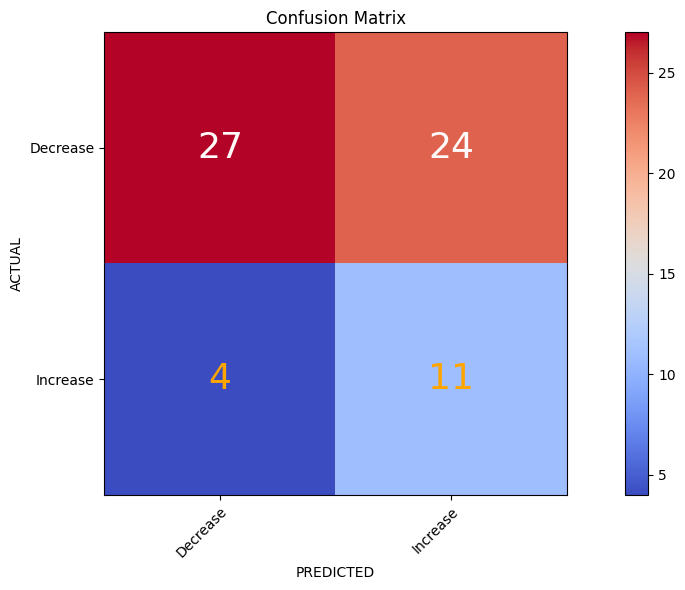

              precision    recall  f1-score   support

    Decrease       0.87      0.53      0.66        51
    Increase       0.31      0.73      0.44        15

    accuracy                           0.58        66
   macro avg       0.59      0.63      0.55        66
weighted avg       0.74      0.58      0.61        66


-------------- GaussianProcessClassifier ---------------



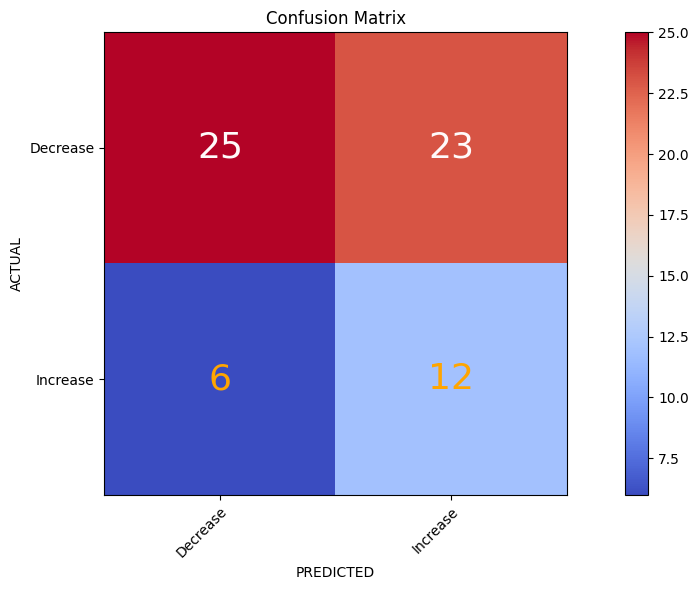

              precision    recall  f1-score   support

    Decrease       0.81      0.52      0.63        48
    Increase       0.34      0.67      0.45        18

    accuracy                           0.56        66
   macro avg       0.57      0.59      0.54        66
weighted avg       0.68      0.56      0.58        66


-------------- RandomForestClassifier ---------------



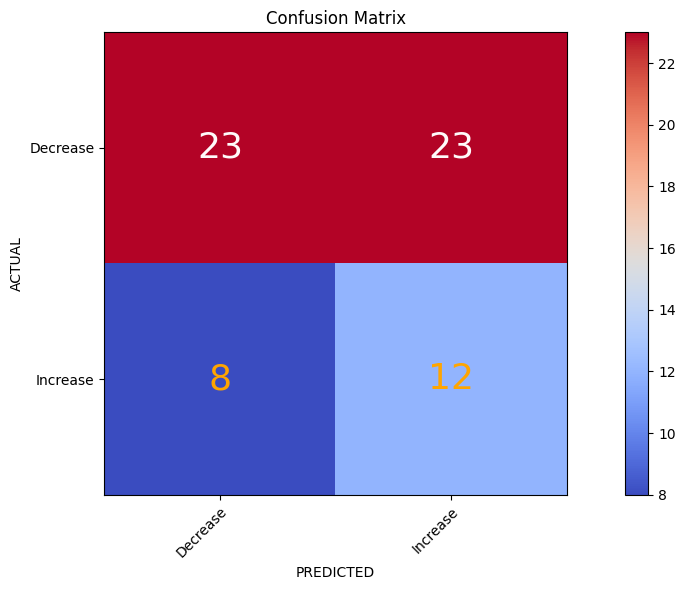

              precision    recall  f1-score   support

    Decrease       0.74      0.50      0.60        46
    Increase       0.34      0.60      0.44        20

    accuracy                           0.53        66
   macro avg       0.54      0.55      0.52        66
weighted avg       0.62      0.53      0.55        66



In [86]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_amzn_train,y_amzn_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_amzn_test),y_amzn_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_amzn_test),y_amzn_test, target_names=['Decrease', 'Increase']))


-------------- LinearDiscriminantAnalysis ---------------



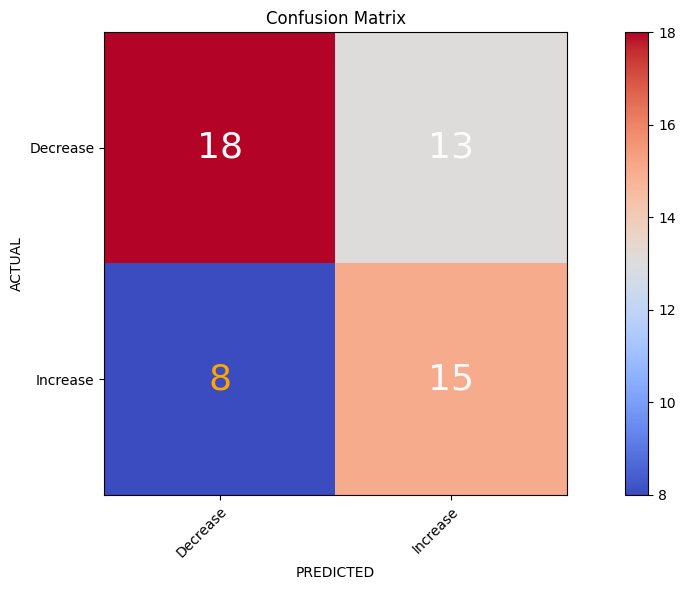

              precision    recall  f1-score   support

    Decrease       0.69      0.58      0.63        31
    Increase       0.54      0.65      0.59        23

    accuracy                           0.61        54
   macro avg       0.61      0.62      0.61        54
weighted avg       0.63      0.61      0.61        54


-------------- SVM Classification ---------------



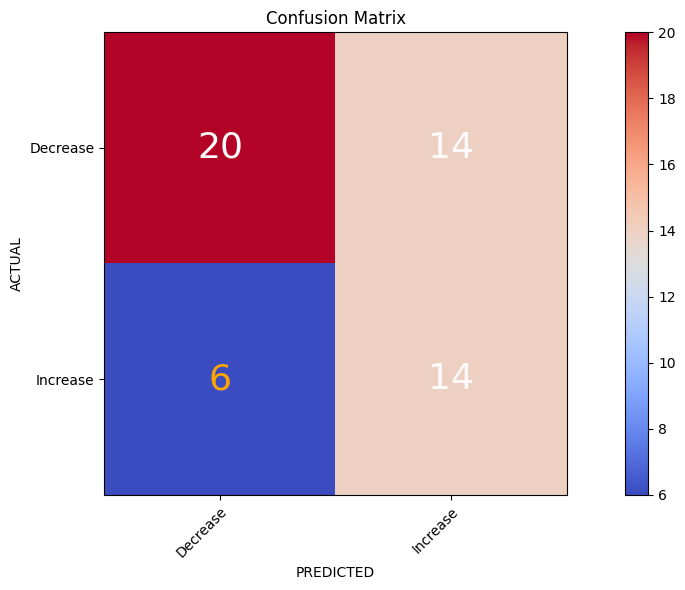

              precision    recall  f1-score   support

    Decrease       0.77      0.59      0.67        34
    Increase       0.50      0.70      0.58        20

    accuracy                           0.63        54
   macro avg       0.63      0.64      0.62        54
weighted avg       0.67      0.63      0.64        54


-------------- SGDClassifier ---------------



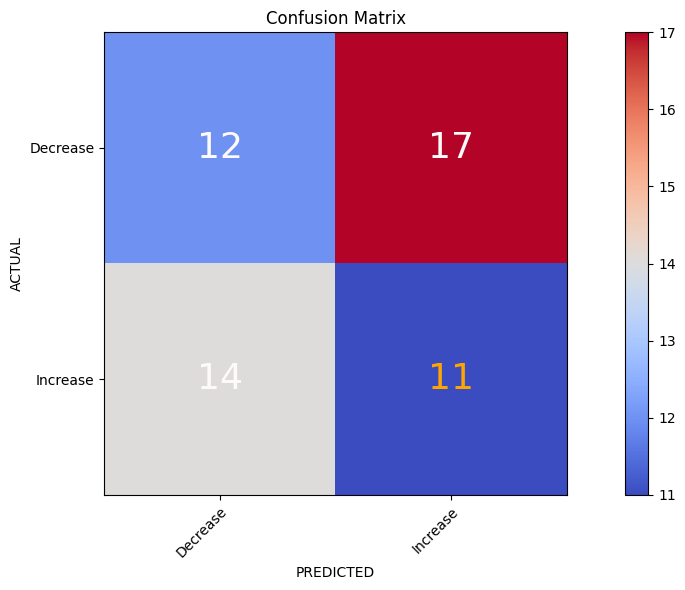

              precision    recall  f1-score   support

    Decrease       0.46      0.41      0.44        29
    Increase       0.39      0.44      0.42        25

    accuracy                           0.43        54
   macro avg       0.43      0.43      0.43        54
weighted avg       0.43      0.43      0.43        54


-------------- KNeighborsClassifier ---------------



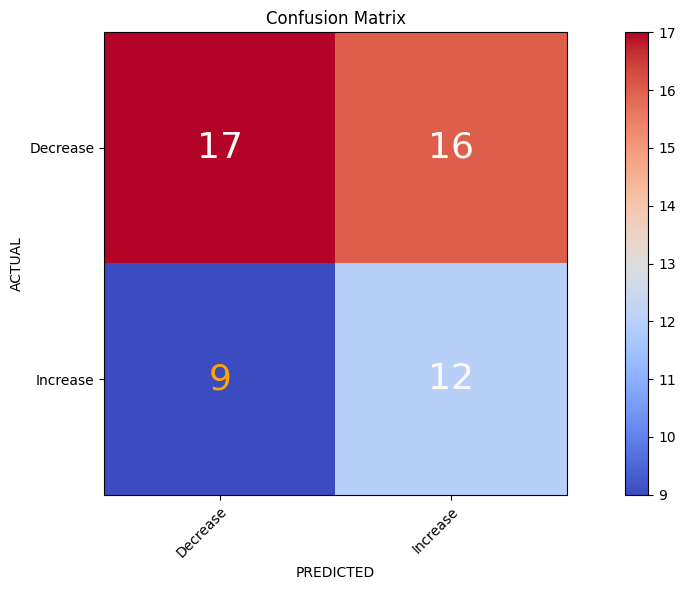

              precision    recall  f1-score   support

    Decrease       0.65      0.52      0.58        33
    Increase       0.43      0.57      0.49        21

    accuracy                           0.54        54
   macro avg       0.54      0.54      0.53        54
weighted avg       0.57      0.54      0.54        54


-------------- GaussianProcessClassifier ---------------



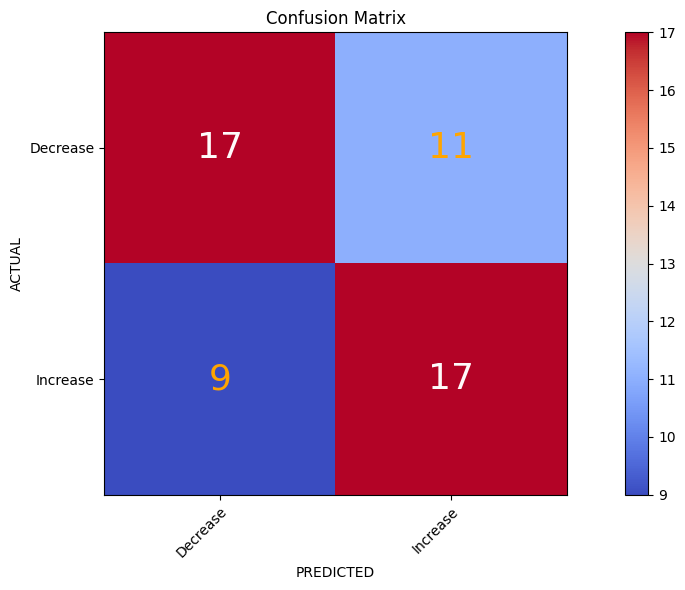

              precision    recall  f1-score   support

    Decrease       0.65      0.61      0.63        28
    Increase       0.61      0.65      0.63        26

    accuracy                           0.63        54
   macro avg       0.63      0.63      0.63        54
weighted avg       0.63      0.63      0.63        54


-------------- RandomForestClassifier ---------------



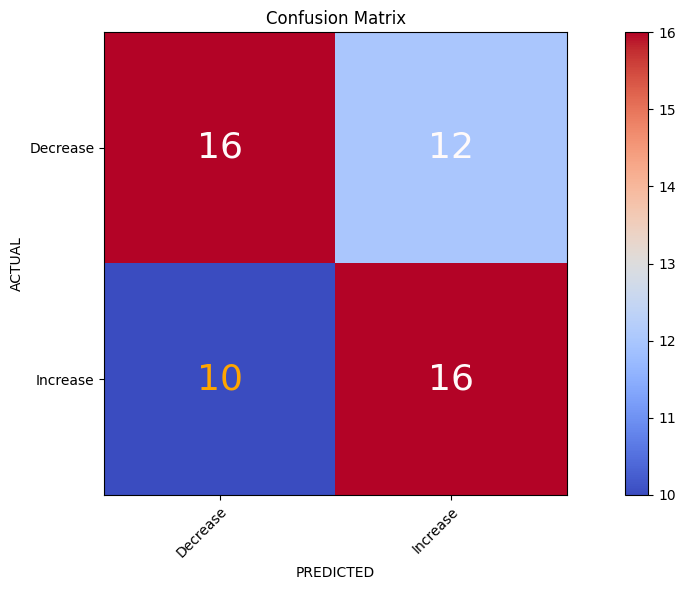

              precision    recall  f1-score   support

    Decrease       0.62      0.57      0.59        28
    Increase       0.57      0.62      0.59        26

    accuracy                           0.59        54
   macro avg       0.59      0.59      0.59        54
weighted avg       0.59      0.59      0.59        54



In [87]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_aapl_train,y_aapl_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_aapl_test),y_aapl_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_aapl_test),y_aapl_test, target_names=['Decrease', 'Increase']))


-------------- LinearDiscriminantAnalysis ---------------



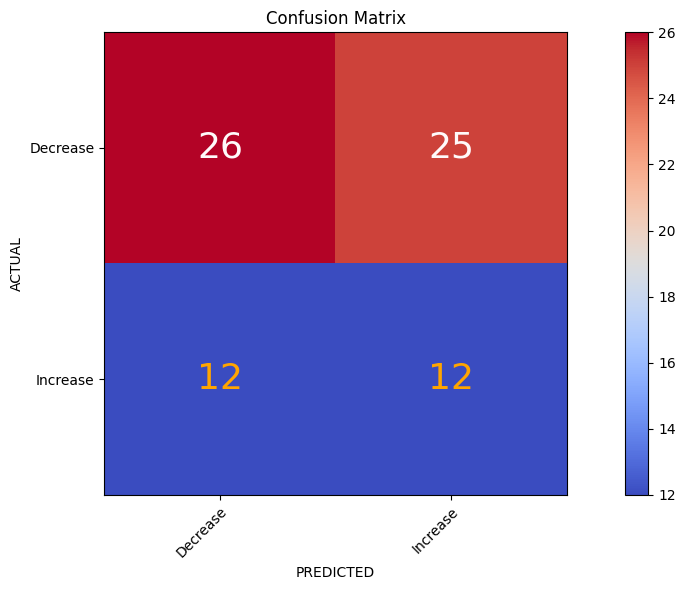

              precision    recall  f1-score   support

    Decrease       0.68      0.51      0.58        51
    Increase       0.32      0.50      0.39        24

    accuracy                           0.51        75
   macro avg       0.50      0.50      0.49        75
weighted avg       0.57      0.51      0.52        75


-------------- SVM Classification ---------------



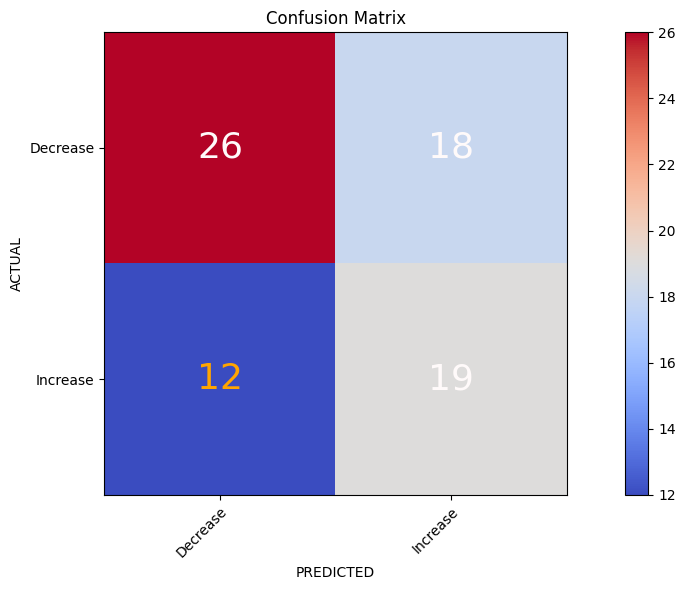

              precision    recall  f1-score   support

    Decrease       0.68      0.59      0.63        44
    Increase       0.51      0.61      0.56        31

    accuracy                           0.60        75
   macro avg       0.60      0.60      0.60        75
weighted avg       0.61      0.60      0.60        75


-------------- SGDClassifier ---------------



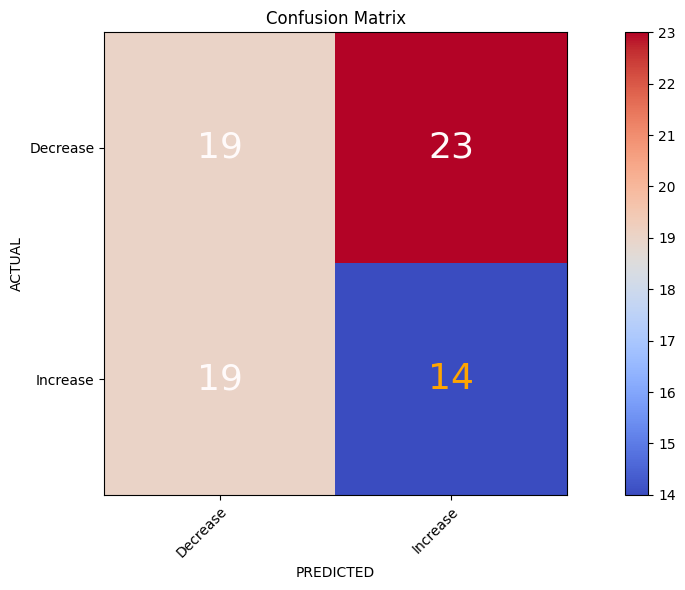

              precision    recall  f1-score   support

    Decrease       0.50      0.45      0.48        42
    Increase       0.38      0.42      0.40        33

    accuracy                           0.44        75
   macro avg       0.44      0.44      0.44        75
weighted avg       0.45      0.44      0.44        75


-------------- KNeighborsClassifier ---------------



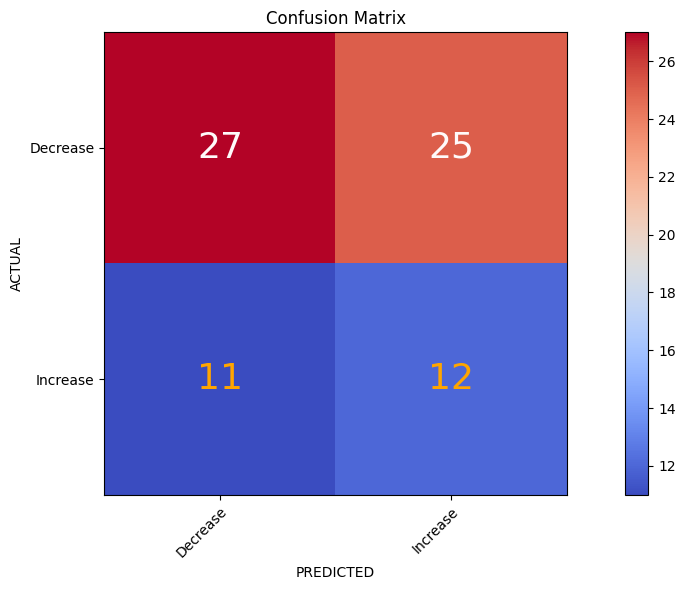

              precision    recall  f1-score   support

    Decrease       0.71      0.52      0.60        52
    Increase       0.32      0.52      0.40        23

    accuracy                           0.52        75
   macro avg       0.52      0.52      0.50        75
weighted avg       0.59      0.52      0.54        75


-------------- GaussianProcessClassifier ---------------



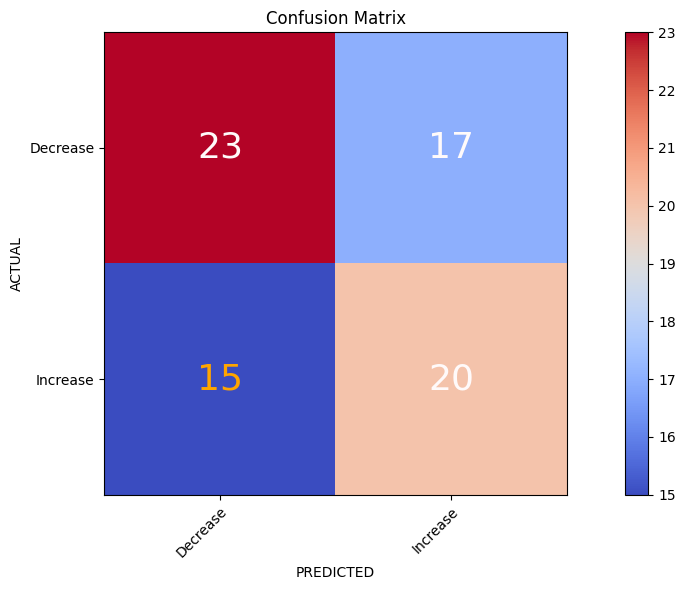

              precision    recall  f1-score   support

    Decrease       0.61      0.57      0.59        40
    Increase       0.54      0.57      0.56        35

    accuracy                           0.57        75
   macro avg       0.57      0.57      0.57        75
weighted avg       0.58      0.57      0.57        75


-------------- RandomForestClassifier ---------------



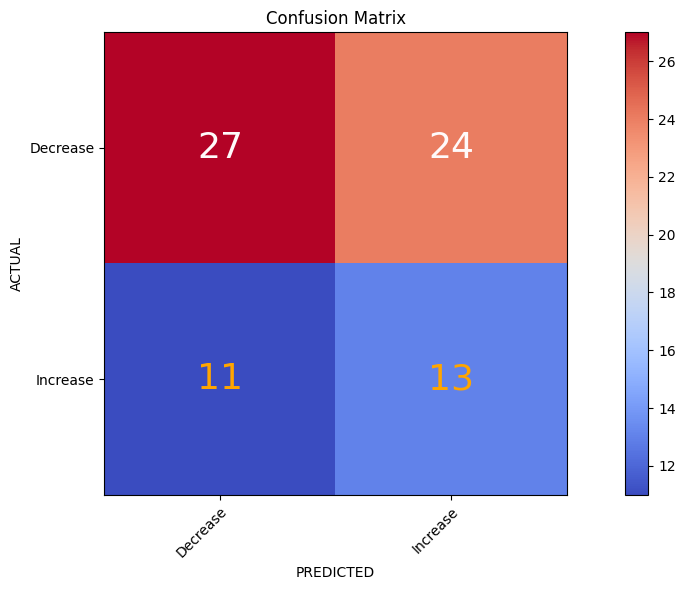

              precision    recall  f1-score   support

    Decrease       0.71      0.53      0.61        51
    Increase       0.35      0.54      0.43        24

    accuracy                           0.53        75
   macro avg       0.53      0.54      0.52        75
weighted avg       0.60      0.53      0.55        75



In [88]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_msft_train,y_msft_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_msft_test),y_msft_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_msft_test),y_msft_test, target_names=['Decrease', 'Increase']))